In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
#from torch.utils.tensorboard import SummaryWriter


In [9]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/competitions/gan-getting-started/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: westobaba
Your Kaggle Key: ··········


100%|██████████| 367M/367M [00:01<00:00, 228MB/s]



Extracting archive ./gan-getting-started/gan-getting-started.zip to ./gan-getting-started


In [11]:
import os

DATA_DIR = '/content/gan-getting-started'
print(os.listdir(DATA_DIR))

['photo_tfrec', 'monet_jpg', 'photo_jpg', 'monet_tfrec']


In [12]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [13]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [21]:
len(dataset)

7038

In [19]:
import os
from torch.utils.data import Dataset
from PIL import Image

class GANImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


In [20]:
data_dir = '/content/gan-getting-started/photo_jpg'

# Define the transform to be applied to the data
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(*stats)])

# Create the dataset
dataset = GANImageDataset(data_dir, transform=transform)

# Create a data loader to load the data in batches
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


In [22]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
 def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [25]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

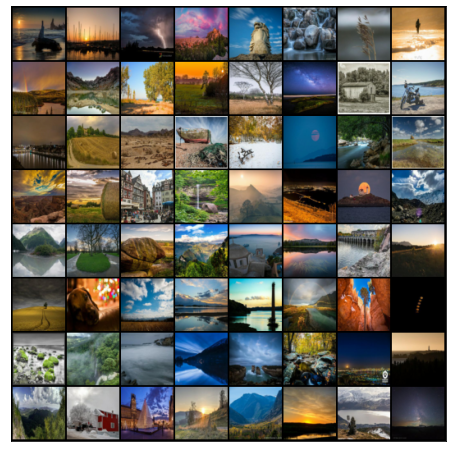

In [26]:
show_batch(data_loader)

In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
device = get_default_device()
device

device(type='cuda')

In [29]:
train_dl = DeviceDataLoader(data_loader, device)

In [30]:
import torch.nn as nn

In [31]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [32]:
discriminator = to_device(discriminator, device)

In [33]:
latent_size = 128

In [34]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


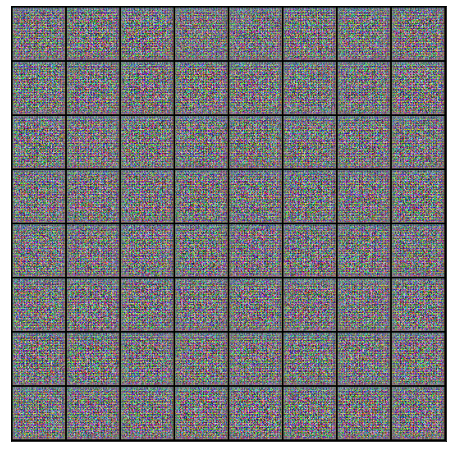

In [35]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [36]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [37]:
generator = to_device(generator, device)

In [38]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [39]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [40]:
from torchvision.utils import save_image

In [41]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [42]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [43]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [44]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [51]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [52]:
lr = 0.0002
epochs = 100

In [53]:
history = fit(epochs, lr)

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 4.8001, loss_d: 0.8506, real_score: 0.9815, fake_score: 0.5037
Saving generated-images-0002.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 4.2561, loss_d: 0.4272, real_score: 0.9463, fake_score: 0.2818
Saving generated-images-0003.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 3.1838, loss_d: 0.3907, real_score: 0.7477, fake_score: 0.0612
Saving generated-images-0004.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 2.9313, loss_d: 0.3905, real_score: 0.8649, fake_score: 0.1945
Saving generated-images-0005.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 3.3732, loss_d: 0.2219, real_score: 0.9347, fake_score: 0.1301
Saving generated-images-0006.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 1.1926, loss_d: 0.7976, real_score: 0.6069, fake_score: 0.1693
Saving generated-images-0007.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 4.1911, loss_d: 0.4761, real_score: 0.8497, fake_score: 0.2429
Saving generated-images-0008.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 4.1375, loss_d: 0.2975, real_score: 0.9640, fake_score: 0.2116
Saving generated-images-0009.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 2.9569, loss_d: 0.4624, real_score: 0.8270, fake_score: 0.2147
Saving generated-images-0010.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 3.9835, loss_d: 0.2191, real_score: 0.8920, fake_score: 0.0900
Saving generated-images-0011.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 3.3682, loss_d: 0.3926, real_score: 0.9425, fake_score: 0.2631
Saving generated-images-0012.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 2.9840, loss_d: 0.3109, real_score: 0.8733, fake_score: 0.1413
Saving generated-images-0013.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 1.9280, loss_d: 0.5738, real_score: 0.7059, fake_score: 0.1271
Saving generated-images-0014.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 1.2755, loss_d: 0.4678, real_score: 0.7122, fake_score: 0.0842
Saving generated-images-0015.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 2.1327, loss_d: 0.3422, real_score: 0.8096, fake_score: 0.0991
Saving generated-images-0016.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 4.7354, loss_d: 0.3407, real_score: 0.8064, fake_score: 0.0842
Saving generated-images-0017.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 2.1658, loss_d: 1.9242, real_score: 0.2038, fake_score: 0.0015
Saving generated-images-0018.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 4.1380, loss_d: 0.2387, real_score: 0.9191, fake_score: 0.1276
Saving generated-images-0019.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 3.1740, loss_d: 0.3522, real_score: 0.8242, fake_score: 0.1196
Saving generated-images-0020.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 1.9870, loss_d: 0.4417, real_score: 0.7155, fake_score: 0.0573
Saving generated-images-0021.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 7.4017, loss_d: 1.4126, real_score: 0.9818, fake_score: 0.6525
Saving generated-images-0022.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 3.5345, loss_d: 0.2891, real_score: 0.9431, fake_score: 0.1847
Saving generated-images-0023.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 2.8228, loss_d: 0.3523, real_score: 0.8942, fake_score: 0.1876
Saving generated-images-0024.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 4.5292, loss_d: 0.4897, real_score: 0.9429, fake_score: 0.3144
Saving generated-images-0025.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 3.0316, loss_d: 1.1060, real_score: 0.4414, fake_score: 0.0083
Saving generated-images-0026.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 3.4600, loss_d: 0.4447, real_score: 0.6969, fake_score: 0.0157
Saving generated-images-0027.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 2.0164, loss_d: 0.4521, real_score: 0.7580, fake_score: 0.1204
Saving generated-images-0028.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 3.3416, loss_d: 0.2601, real_score: 0.8403, fake_score: 0.0685
Saving generated-images-0029.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 5.4004, loss_d: 0.2113, real_score: 0.8347, fake_score: 0.0076
Saving generated-images-0030.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 3.5998, loss_d: 0.3657, real_score: 0.8986, fake_score: 0.1923
Saving generated-images-0031.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.6804, loss_d: 0.2764, real_score: 0.7963, fake_score: 0.0219
Saving generated-images-0032.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 2.7085, loss_d: 0.2940, real_score: 0.8700, fake_score: 0.1243
Saving generated-images-0033.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 2.9698, loss_d: 0.4381, real_score: 0.8557, fake_score: 0.1954
Saving generated-images-0034.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 3.9134, loss_d: 0.1220, real_score: 0.9488, fake_score: 0.0638
Saving generated-images-0035.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 3.0417, loss_d: 0.2038, real_score: 0.8968, fake_score: 0.0822
Saving generated-images-0036.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 4.7209, loss_d: 0.1032, real_score: 0.9279, fake_score: 0.0233
Saving generated-images-0037.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 3.1005, loss_d: 0.4070, real_score: 0.7849, fake_score: 0.0885
Saving generated-images-0038.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 2.6258, loss_d: 0.2375, real_score: 0.8694, fake_score: 0.0720
Saving generated-images-0039.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 3.6941, loss_d: 0.1861, real_score: 0.8897, fake_score: 0.0541
Saving generated-images-0040.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 2.7420, loss_d: 0.3261, real_score: 0.8464, fake_score: 0.1289
Saving generated-images-0041.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 3.3452, loss_d: 0.1980, real_score: 0.8928, fake_score: 0.0705
Saving generated-images-0042.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 4.3618, loss_d: 0.1637, real_score: 0.9623, fake_score: 0.1083
Saving generated-images-0043.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 5.0668, loss_d: 0.1607, real_score: 0.8816, fake_score: 0.0165
Saving generated-images-0044.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 3.5870, loss_d: 0.0958, real_score: 0.9597, fake_score: 0.0505
Saving generated-images-0045.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 3.7076, loss_d: 0.1130, real_score: 0.9398, fake_score: 0.0458
Saving generated-images-0046.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 6.0521, loss_d: 0.3517, real_score: 0.9903, fake_score: 0.2474
Saving generated-images-0047.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 3.1290, loss_d: 0.1123, real_score: 0.9221, fake_score: 0.0249
Saving generated-images-0048.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 1.7547, loss_d: 0.4056, real_score: 0.7564, fake_score: 0.0535
Saving generated-images-0049.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 3.7211, loss_d: 0.1418, real_score: 0.9534, fake_score: 0.0849
Saving generated-images-0050.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 3.7398, loss_d: 0.0902, real_score: 0.9452, fake_score: 0.0313
Saving generated-images-0051.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 3.8232, loss_d: 0.0788, real_score: 0.9590, fake_score: 0.0339
Saving generated-images-0052.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 2.9926, loss_d: 0.1947, real_score: 0.9343, fake_score: 0.1064
Saving generated-images-0053.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 3.3192, loss_d: 0.2222, real_score: 0.9265, fake_score: 0.1211
Saving generated-images-0054.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 3.2803, loss_d: 0.1197, real_score: 0.9366, fake_score: 0.0493
Saving generated-images-0055.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 3.6265, loss_d: 0.1317, real_score: 0.9384, fake_score: 0.0587
Saving generated-images-0056.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 2.4783, loss_d: 0.8023, real_score: 0.7104, fake_score: 0.1934
Saving generated-images-0057.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 2.8370, loss_d: 0.1655, real_score: 0.8808, fake_score: 0.0294
Saving generated-images-0058.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 3.9582, loss_d: 0.1215, real_score: 0.9062, fake_score: 0.0147
Saving generated-images-0059.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 3.9582, loss_d: 0.1797, real_score: 0.9021, fake_score: 0.0645
Saving generated-images-0060.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 5.3226, loss_d: 0.8760, real_score: 0.8900, fake_score: 0.4377
Saving generated-images-0061.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 2.9530, loss_d: 0.2263, real_score: 0.8487, fake_score: 0.0456
Saving generated-images-0062.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 3.7401, loss_d: 0.1075, real_score: 0.9389, fake_score: 0.0389
Saving generated-images-0063.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 4.5172, loss_d: 0.0993, real_score: 0.9768, fake_score: 0.0689
Saving generated-images-0064.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 6.3041, loss_d: 4.3295, real_score: 0.8947, fake_score: 0.9001
Saving generated-images-0065.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.9772, loss_d: 0.1838, real_score: 0.9570, fake_score: 0.1181
Saving generated-images-0066.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 2.6616, loss_d: 0.2502, real_score: 0.8714, fake_score: 0.0849
Saving generated-images-0067.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.6331, loss_d: 0.0966, real_score: 0.9659, fake_score: 0.0577
Saving generated-images-0068.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 4.8612, loss_d: 0.4532, real_score: 0.9234, fake_score: 0.2559
Saving generated-images-0069.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 2.6731, loss_d: 0.1626, real_score: 0.8898, fake_score: 0.0397
Saving generated-images-0070.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 5.0548, loss_d: 0.0671, real_score: 0.9573, fake_score: 0.0222
Saving generated-images-0071.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 4.1936, loss_d: 0.1082, real_score: 0.9874, fake_score: 0.0865
Saving generated-images-0072.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 3.5716, loss_d: 0.0962, real_score: 0.9600, fake_score: 0.0484
Saving generated-images-0073.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 4.3872, loss_d: 0.0881, real_score: 0.9339, fake_score: 0.0171
Saving generated-images-0074.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 4.7922, loss_d: 0.0568, real_score: 0.9742, fake_score: 0.0291
Saving generated-images-0075.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 4.4974, loss_d: 0.0818, real_score: 0.9922, fake_score: 0.0653
Saving generated-images-0076.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 1.3116, loss_d: 0.5790, real_score: 0.7076, fake_score: 0.1140
Saving generated-images-0077.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 2.9055, loss_d: 0.2030, real_score: 0.9196, fake_score: 0.1000
Saving generated-images-0078.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 3.6219, loss_d: 0.1452, real_score: 0.8834, fake_score: 0.0142
Saving generated-images-0079.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 4.8573, loss_d: 0.0804, real_score: 0.9876, fake_score: 0.0605
Saving generated-images-0080.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 4.1308, loss_d: 0.0641, real_score: 0.9608, fake_score: 0.0227
Saving generated-images-0081.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.2860, loss_d: 0.1112, real_score: 0.9301, fake_score: 0.0345
Saving generated-images-0082.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 3.2751, loss_d: 0.8325, real_score: 0.6592, fake_score: 0.1745
Saving generated-images-0083.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 3.2485, loss_d: 0.1321, real_score: 0.9311, fake_score: 0.0493
Saving generated-images-0084.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 4.1713, loss_d: 0.1105, real_score: 0.9864, fake_score: 0.0842
Saving generated-images-0085.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.0353, loss_d: 0.0513, real_score: 0.9710, fake_score: 0.0206
Saving generated-images-0086.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 4.4732, loss_d: 0.0444, real_score: 0.9799, fake_score: 0.0231
Saving generated-images-0087.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 4.8171, loss_d: 0.0492, real_score: 0.9769, fake_score: 0.0246
Saving generated-images-0088.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 5.4624, loss_d: 0.0775, real_score: 0.9419, fake_score: 0.0152
Saving generated-images-0089.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 4.7757, loss_d: 0.0441, real_score: 0.9855, fake_score: 0.0261
Saving generated-images-0090.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 2.9801, loss_d: 2.2523, real_score: 0.9014, fake_score: 0.7597
Saving generated-images-0091.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 5.9745, loss_d: 1.0243, real_score: 0.9469, fake_score: 0.4771
Saving generated-images-0092.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 3.9744, loss_d: 0.0879, real_score: 0.9639, fake_score: 0.0466
Saving generated-images-0093.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 2.6394, loss_d: 0.2341, real_score: 0.8246, fake_score: 0.0262
Saving generated-images-0094.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 4.2030, loss_d: 0.1087, real_score: 0.9518, fake_score: 0.0513
Saving generated-images-0095.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 5.1950, loss_d: 0.0793, real_score: 0.9715, fake_score: 0.0445
Saving generated-images-0096.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 4.3344, loss_d: 0.0905, real_score: 0.9518, fake_score: 0.0350
Saving generated-images-0097.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 4.2435, loss_d: 0.0558, real_score: 0.9789, fake_score: 0.0321
Saving generated-images-0098.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 4.0465, loss_d: 0.0799, real_score: 0.9526, fake_score: 0.0287
Saving generated-images-0099.png


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 5.0565, loss_d: 0.0797, real_score: 0.9692, fake_score: 0.0447
Saving generated-images-0100.png
